In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/media/beans/ssd/bespoke')
sys.path.append(f'/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from train_utils import *
from input_prep import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Seq from real

In [36]:
sorted(glob.glob("/media/beans/ssd/bespoke_logging/*"))
#sorted(glob.glob("/home/beans/bespoke_logging/*"))

['/media/beans/ssd/bespoke_logging/run_351',
 '/media/beans/ssd/bespoke_logging/run_352',
 '/media/beans/ssd/bespoke_logging/run_353',
 '/media/beans/ssd/bespoke_logging/run_354',
 '/media/beans/ssd/bespoke_logging/run_355',
 '/media/beans/ssd/bespoke_logging/run_356',
 '/media/beans/ssd/bespoke_logging/run_357',
 '/media/beans/ssd/bespoke_logging/run_358',
 '/media/beans/ssd/bespoke_logging/run_359',
 '/media/beans/ssd/bespoke_logging/run_359a',
 '/media/beans/ssd/bespoke_logging/run_359b',
 '/media/beans/ssd/bespoke_logging/run_360',
 '/media/beans/ssd/bespoke_logging/run_361',
 '/media/beans/ssd/bespoke_logging/run_362',
 '/media/beans/ssd/bespoke_logging/run_363',
 '/media/beans/ssd/bespoke_logging/run_364',
 '/media/beans/ssd/bespoke_logging/run_365',
 '/media/beans/ssd/bespoke_logging/run_366',
 '/media/beans/ssd/bespoke_logging/run_367',
 '/media/beans/ssd/bespoke_logging/run_368',
 '/media/beans/ssd/bespoke_logging/run_369',
 '/media/beans/ssd/bespoke_logging/run_370',
 '/media

In [37]:
#run_id = "run_382" # out sabq to pow to grade
#run_id = "run_383" # back from grade, 214, madrona, sunny
#run_id = "run_392" # back from nabq, creeper on ev, sunny
run_id = "run_396" # back from nabq, on 213, cloudy
#run_id = "run_402" # back from nabq, on 213, sunny
#run_id = "run_404" # # out to end sabq
#run_id = "run_412" # back from end nabq, sunny


run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"
#run_path = f"/home/beans/bespoke_logging/{run_id}"

model_stem = "7.23_avg"

In [38]:
s, e = 0, -1 #4000

In [39]:
aux = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/aux/*"))[s:e]]).astype(np.float16)
img = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/img/*"))[s:e]]).astype(np.uint8)
car_state = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/car_state/*"))[s:e]]).astype(np.float16)

steer_angle = np.radians(car_state[:,0] / (STEER_RATIO)) #*-1  
tire_angle_rad = steer_angle *-1
img.shape

(20415, 100, 640, 3)

In [40]:
commanded_torque = car_state[:, 7]

array([   36.,    15.,    37.,    92.,    84.,   498.,  2591., 13432.,
        3097.,   533.])

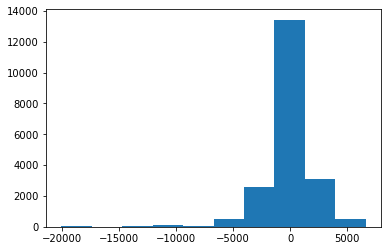

In [41]:
plt.hist(commanded_torque)[0]

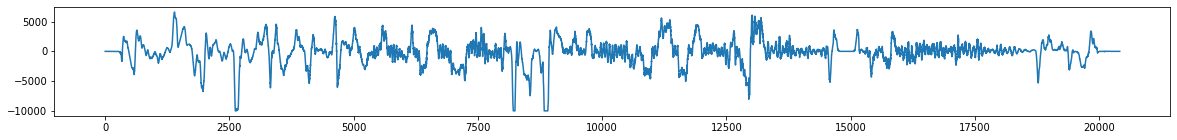

In [42]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_torque, -10_000, 10_000))

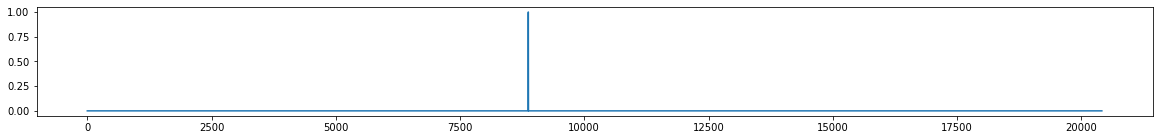

In [43]:
# abs torque limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 9])

array([ 551.,  117.,  241., 1630., 7653., 8440., 1131.,  308.,  164.,
        180.])

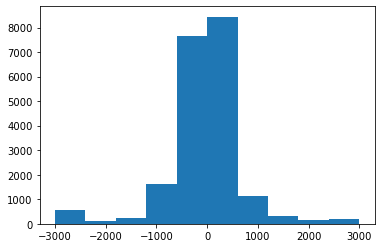

In [44]:
commanded_td = car_state[:, 8]
plt.hist(np.clip(commanded_td, -3000, 3000))[0]

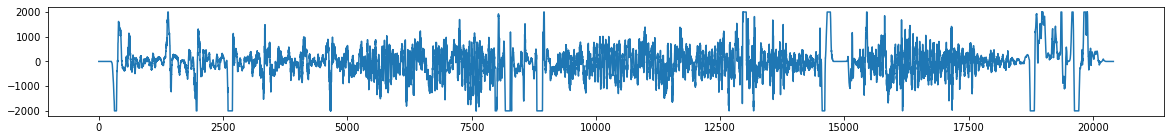

In [45]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_td, -2000, 2000))

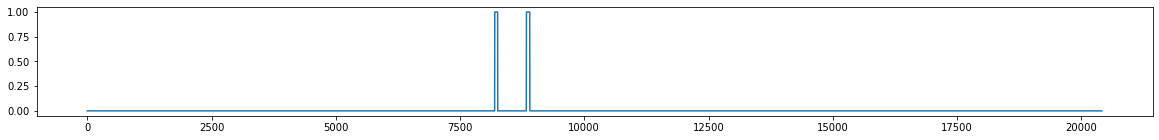

In [46]:
# Td limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 10])

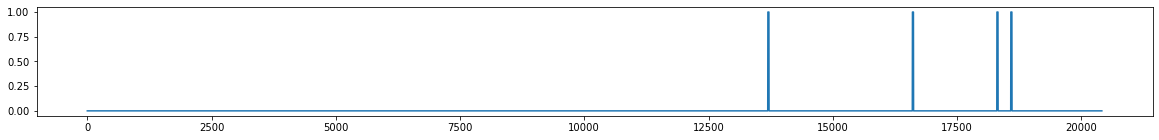

In [47]:
# interesting note
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 11])

In [48]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(car_state[:, 10], width=900, height=400)
fig.show()

In [49]:
#plt.imshow(img[15_750])

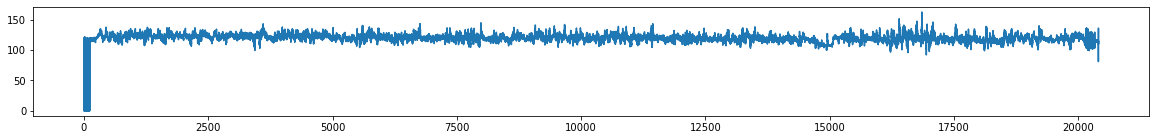

In [50]:
# seeing if cam is too slow, ie if we ever have repeated imgs

diffs = []
for i in range(len(img)-1):
    diff = (img[i] - img[i+1]).mean()
    diffs.append(diff)
    
# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros
plt.figure(figsize=(20,2))
plt.plot(diffs)

(array([8.9520e+03, 1.0036e+04, 1.2880e+03, 3.9000e+01, 3.3000e+01,
        2.2000e+01, 2.2000e+01, 4.0000e+00, 6.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([18.  , 19.45, 20.9 , 22.34, 23.8 , 25.25, 26.7 , 28.16, 29.6 ,
        31.05, 32.5 , 33.94, 35.4 , 36.84, 38.3 , 39.75, 41.2 , 42.66,
        44.1 , 45.56, 47.  ], dtype=float16),
 <BarContainer object of 20 artists>)

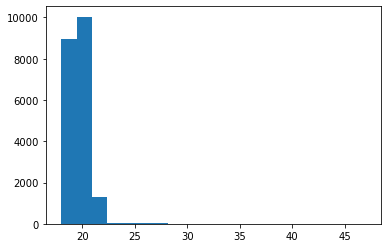

In [51]:
# timespan btwn start to get img, and publish plan, ie the timespan WE have control over
# img staleness
plt.hist(car_state[:,2], bins=20)

In [52]:
b,e = 0, -1
img = img[b:e]
aux = aux[b:e]
car_state = car_state[b:e]
steer_angle = steer_angle[b:e]
img.shape, aux.shape, car_state.shape, steer_angle.shape, #pred.shape

((20414, 100, 640, 3), (20414, 5), (20414, 12), (20414,))

(array([  20.,   10.,  182.,  972., 1307., 4619., 9973., 1674., 1294.,
         363.]),
 array([-9504., -7956., -6408., -4860., -3312., -1764.,  -216.,  1332.,
         2880.,  4428.,  5976.], dtype=float16),
 <BarContainer object of 10 artists>)

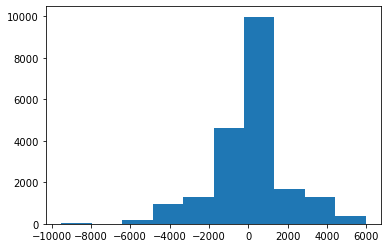

In [53]:
torque = np.degrees(steer_angle) * (aux[:,2]**2)
plt.hist(torque)

(array([1.0000e+00, 4.0000e+00, 1.1000e+01, 9.2000e+01, 9.4000e+02,
        1.2781e+04, 5.9600e+03, 5.3700e+02, 7.6000e+01, 1.1000e+01]),
 array([-748. , -621.5, -494.8, -368.2, -241.6, -115. ,   11.6,  138.2,
         264.8,  391.5,  518. ], dtype=float16),
 <BarContainer object of 10 artists>)

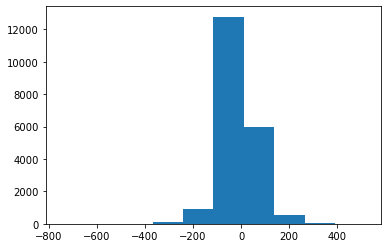

In [54]:
plt.hist(torque[1:]-torque[:-1])

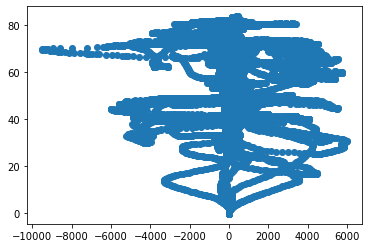

In [55]:
plt.scatter(torque, aux[:,2])

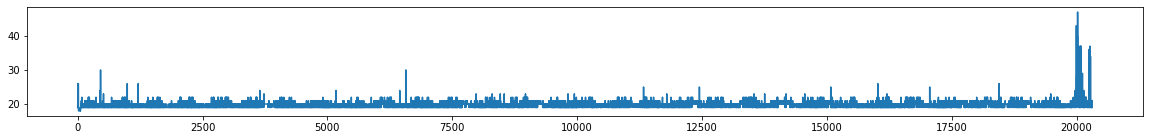

In [56]:
# img staleness
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,2])

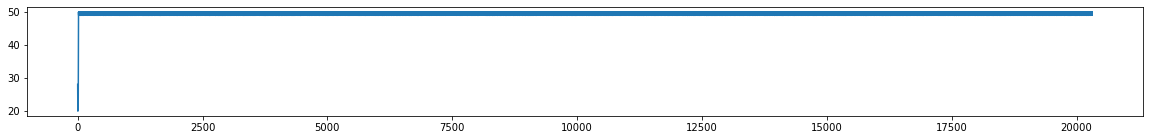

In [57]:
# loop duration
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,3])

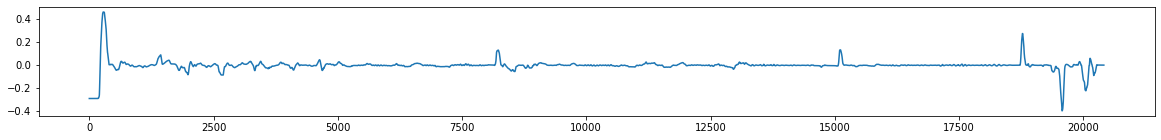

In [58]:
# steer angle
plt.figure(figsize=(20,2))
plt.plot(steer_angle)

In [59]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=range(len(steer_angle)), y=steer_angle, width=900, height=400)
fig.show()

(array([   36.,   232.,   101.,   337., 19021.,   416.,   118.,    56.,
           27.,    70.]),
 array([-0.3958 , -0.3098 , -0.2239 , -0.138  , -0.052  ,  0.03394,
         0.1199 ,  0.2058 ,  0.2917 ,  0.3777 ,  0.4636 ], dtype=float16),
 <BarContainer object of 10 artists>)

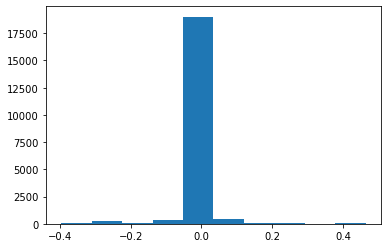

In [60]:
plt.hist(steer_angle)

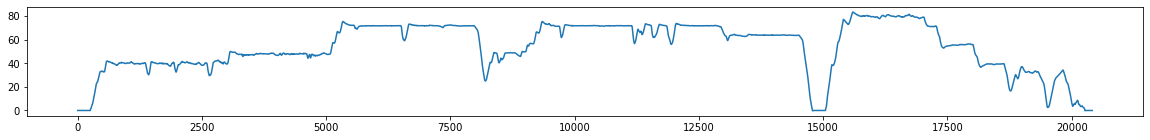

In [61]:
# speed
plt.figure(figsize=(20,2))
plt.plot(aux[:,2])

(array([1126.,  210.,  370., 1105., 3194., 2996., 1134., 2415., 6236.,
        1628.]),
 array([-0.3257,  8.08  , 16.48  , 24.88  , 33.28  , 41.7   , 50.1   ,
        58.47  , 66.9   , 75.3   , 83.7   ], dtype=float16),
 <BarContainer object of 10 artists>)

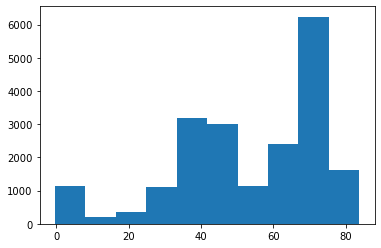

In [62]:
# speed
plt.hist(aux[:,2])

In [63]:
"""import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)
#fig.update_xaxes(range=[0, 50])
fig.update_yaxes(range=[0, 12])
fig.show()
"""
# The speed you can go is a linear fn of sqrt(1/curvature), or of steer_angle bc that's linear fn of curvature, given wheelbase

'import plotly.express as px\nimport plotly.graph_objects as go\n\nfig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)\n#fig.update_xaxes(range=[0, 50])\nfig.update_yaxes(range=[0, 12])\nfig.show()\n'

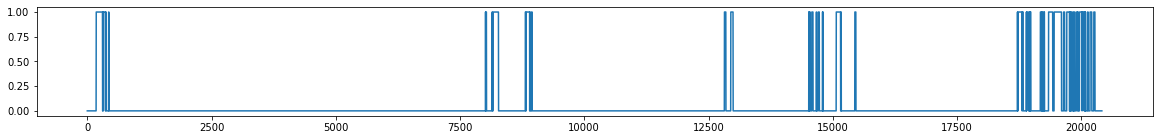

In [64]:
# steeringWheelPressed
plt.figure(figsize=(20,2))
plt.plot(car_state[:,4])

(array([  772075.,  5597026., 10312681.,  9167543.,  9403201.,  9868232.,
        14477467.,  5147032.,   451272.,   147471.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

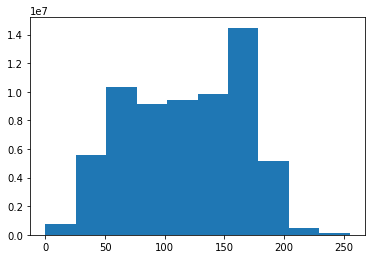

In [65]:
plt.hist(img[::20,:,:,2].flatten())

In [66]:
img.mean()

134.3574632707129

In [67]:
make_vid(run_id, model_stem, img, aux)

(20414, 30) (20414, 1, 13, 80) (20414, 1, 13, 80)
Made vid!


In [68]:
%%time
combine_vids(model_stem, "7.10_avg", run_id)

combined!
CPU times: user 54.6 s, sys: 528 ms, total: 55.1 s
Wall time: 55.1 s
